In [1]:
import sys
import os
sys.path.append("../../")

from pathlib import Path
import pandas as pd
import evaluate
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification
import torch
from directories_constants import *
from data_manipulation import *
from preprocessing import create_datasets, train_test_split
import numpy as np


COLAB = 'google.colab' in sys.modules
if COLAB:
    torch.cuda.is_available
    from google.colab import drive
    drive.mount('/content/drive')
    %load_ext tensorboard
COLAB

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512,garbage_collection_threshold:0.9"

c:\virtual environments\natural_language_1.0\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

tru_label = ['O',
              'B-cond',
              'I-cond',
              'B-des',
              'I-des',
              'B-subj',
              'I-subj',
              "B-group_A",
              "I-group_A",
              "B-group_B",
              "I-group_B",
              "B-group_C",
              "I-group_C",
              'B-group_D',
              'I-group_D',
              # 'B-proc',
              # 'I-proc',
              # 'B-N_A',
              # 'I-N_A',
              # 'B-N_B',
              # 'I-N_B',
              # 'B-ther',
              # 'I-ther'
             ]

id2label = {i:label for i, label in enumerate(tru_label) }
label2id = {label:i for i, label in enumerate(tru_label) }
id2label

{0: 'O',
 1: 'B-cond',
 2: 'I-cond',
 3: 'B-des',
 4: 'I-des',
 5: 'B-subj',
 6: 'I-subj',
 7: 'B-group_A',
 8: 'I-group_A',
 9: 'B-group_B',
 10: 'I-group_B',
 11: 'B-group_C',
 12: 'I-group_C',
 13: 'B-group_D',
 14: 'I-group_D'}

#### Reading the datasest

In [3]:
if COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/ner/data/swt")# path for processed data from data preprocessing.ipynb
    MODELS_BASE_PATH = Path("/content/drive/MyDrive/ner/models")# path to save model
else:
    folder_path = Path(PROCESSED_DATA_PATH)# path for processed data from data preprocessing.ipynb
    MODELS_BASE_PATH = Path(BASE_MODELS_PATH)# path to save model


In [4]:
import json

def read_file(folder_path, doc): 
    file_path = doc + '.json'
    file_name = os.path.join(folder_path, file_path )

    with open(file_name, "r", encoding="utf-8") as f:
        return json.load(f)

In [5]:
file_names = ["base_abstract_with_punc_base_2023_12_03", "base_abstract_meth_with_punc_2023_12_03", "base_50_abstract_meth_with_punc_2023_12_03", "base_512_abstract_meth_with_punc_2023_12_03"]
abstract_with_punc= read_file(folder_path, file_names[0])
abstract_meth_with_punc = read_file(folder_path, file_names[1])
abstract_meth_50_with_punc = read_file(folder_path, file_names[2])
abstract_meth_512_with_punc =read_file(folder_path, file_names[3])


#### FUNCTIONS

In [6]:


def tokenize_align_labels(example, label_all_tokens = True):
    # tokenized_input = tokenizer(example['tokens'], truncation = True, is_split_into_words=True, max_length = 512)
    tokenized_input = tokenizer(example['tokens'], truncation = True, is_split_into_words=True)

    labels = []
    for i , label in enumerate(example['ner_tags']):
        word_ids = tokenized_input.word_ids(batch_index=i)
        previous_word_idx = None

        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_ids!= previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_input['labels'] = labels
    return tokenized_input

# def create_datasets(doc_dict, labels):
#     temp = Dataset.from_pandas(pd.DataFrame(doc_dict))
#     temp = temp.cast_column("ner_tags", datasets.Sequence(datasets.ClassLabel(names=labels)))
#     return temp

# def train_test_split(data_set, train_test_size, validation_size):
#     from datasets import DatasetDict
#     train_testvalid = data_set.train_test_split(test_size=train_test_size)

#     # Split the test to half test, half valid
#     test_valid = train_testvalid['test'].train_test_split(test_size=validation_size)

#     #Gather everything into one dataset dictionary
#     train_test_valid_dataset = DatasetDict({
#     'train': train_testvalid['train'],
#     'test': test_valid['test'],
#     'valid': test_valid['train']})

#     return train_test_valid_dataset



#### HYPERPARAMETERS

Here we define the function and hyperparameters which will be used by the model to train the dataset. Majority of the hyperparameters are defined here while some are defined in each different dataset *(Abstract, Abstract + Method, 50 Abstract + Method, 512 Abstracct + Method)*. The hyperparameters defined in the datasets where varied in accordance to the dataset size ie they are the variable hyperparameters used to get the optimal model. 

- **MODEL CHECKPOINT** - this is the saved name for a model in the huggingface repository. Using this we can get the saved weights of the pretrained language model from huggingface More info at __[Huggingface checkpointing](https://huggingface.co/docs/accelerate/usage_guides/checkpoint)__
- **DATA COLLATOR** - this gets the data in batches and feeds it to the model for training. More info at __[Huggingface Data Collator](https://huggingface.co/docs/transformers/main_classes/data_collator)__
- **TOKENIZER**- We use the fast tokenizer here. which speeds up the tokenization process. Tokenization generally maps the string to a token space which can be understood by the model in training. __[Huggingface Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer)__
- **COMPUTE_METRICS_BY_TOKEN_SWT** - Based of the compute metrics on huggingface we modeified it to compute the f1 score of every individual tag used in the model. 
- **MODEL MAX LENGTH** - The token maximuum length for the transformer model. 
- **GRADIENT ACCUMULATION STEPS**- We used this because our batch size couldnt train on one GPU. when training on google colab this is set to 1. 
- **EPOCHS**- Number of time the dataset set should passed through the algorithm

In [7]:
model_checkpoint = "kamalkraj/BioELECTRA-PICO" #BIOELECTRA
# model_checkpoint = "michiyasunaga/BioLinkBERT-base" # BIOLINKBERT
# model_checkpoint = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext" # PUBMEDBERT
# model_checkpoint = "yikuan8/Clinical-Longformer" # CLINICAL-LONGFORMER


tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, model_max_length = 512)


In [8]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

In [9]:
from typing import Tuple
from sklearn.metrics import precision_score, recall_score
from functools import partial

def token_f1_cond(true, pred, labels):
    class_scores = zip(labels, precision_score(true, pred, labels=labels, average=None, zero_division=True),
                       recall_score(true, pred, labels=labels, average=None))
    result = {label: {"f1": get_f1(prec, rec), "p": prec, "r": rec} for label, prec, rec in class_scores}
    return result
def get_f1(prec, rec):
    return 2 * prec * rec / (prec + rec)

def compute_metrics_by_token_swt(p: Tuple[list, list], label_list):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [label_list[p] for prediction, label in zip(predictions, labels) for (p, l) in
                        zip(prediction, label) if l != -100]
    true_labels = [label_list[l] for prediction, label in zip(predictions, labels) for (p, l) in zip(prediction, label)
                   if l != -100]

    metrics_report = token_f1_cond(true_labels, true_predictions, label_list)
    metrics_report_f1 = {"f1_" + k: v["f1"] for k, v in metrics_report.items() if k != "O"}
    return metrics_report_f1
compute_metrics_by_token_swt = partial(compute_metrics_by_token_swt, label_list=tru_label)


In [10]:
from transformers import TrainingArguments, Trainer

model_max_length = 512

if COLAB:
    batch_size = 16 # for p-100 16 is ok. For T4: 12
    if model_max_length <= 384:
      # at least 15 GB gpu
        batch_size = 16
    gradient_accumulation_steps = 1
    num_train_epochs = 8
else:
    batch_size = 4
    if model_max_length==256:
        batch_size = 9

    gradient_accumulation_steps = 4
    num_train_epochs = 8


### ABSTRACT with punctuation

In [11]:
learning_rate = 5E-04
weight_decay = 0.003
print(f"bs: {batch_size}, model_max_length: {model_max_length}, gradient_acc_steps: {gradient_accumulation_steps}, \
n_epochs: {num_train_epochs}, lr: {learning_rate}, weight_decay: {weight_decay}")

bs: 4, model_max_length: 512, gradient_acc_steps: 4, n_epochs: 8, lr: 0.0005, weight_decay: 0.003


In [12]:
# visualizing the token and the corresponding tag from the label_dict
for token, label in zip(abstract_with_punc[0]['tokens'], abstract_with_punc[0]['ner_tags']):
    print(f"{token:_<40} {label}")

effects_________________________________ 0
of______________________________________ 0
rivastigmine____________________________ 11
in______________________________________ 0
patients________________________________ 0
with____________________________________ 0
and_____________________________________ 0
without_________________________________ 0
visual__________________________________ 0
hallucinations__________________________ 0
in______________________________________ 0
dementia________________________________ 0
associated______________________________ 0
with____________________________________ 0
parkinson’s_____________________________ 0
disease_________________________________ 0
._______________________________________ 0
we______________________________________ 0
aimed___________________________________ 0
to______________________________________ 0
determine_______________________________ 0
prospectively___________________________ 0
whether_________________________________ 0
rivastigmi

#### Creating Huggingface Dataset

In [13]:
abstract_with_punc_hf_ds = create_datasets(abstract_with_punc, tru_label)

Casting the dataset: 100%|██████████| 1549/1549 [00:00<00:00, 22182.84 examples/s]


In [14]:
abstract_with_punc_hf_ds.features

{'pmid': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-cond', 'I-cond', 'B-des', 'I-des', 'B-subj', 'I-subj', 'B-group_A', 'I-group_A', 'B-group_B', 'I-group_B', 'B-group_C', 'I-group_C', 'B-group_D', 'I-group_D'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [15]:
abstract_with_punc_hf_ds_train_test_valid = train_test_split(abstract_with_punc_hf_ds, train_test_size=0.2, validation_size=0.5)


In [16]:
abstract_with_punc_hf_ds_train_test_valid

DatasetDict({
    train: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 1239
    })
    test: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 155
    })
    valid: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 155
    })
})

In [17]:
tags = abstract_with_punc_hf_ds_train_test_valid['train'].features['ner_tags'].feature.names
tags

['O',
 'B-cond',
 'I-cond',
 'B-des',
 'I-des',
 'B-subj',
 'I-subj',
 'B-group_A',
 'I-group_A',
 'B-group_B',
 'I-group_B',
 'B-group_C',
 'I-group_C',
 'B-group_D',
 'I-group_D']

#### Tokenizer Example and Testing

In [18]:
example_text = abstract_with_punc_hf_ds_train_test_valid['train'][0]
example_text['tokens']

['feasibility',
 'and',
 'baseline',
 'findings',
 'of',
 'a',
 'finnish',
 'cognitive',
 'training',
 '(',
 'fincog',
 ')',
 'intervention',
 'in',
 'a',
 'randomised',
 'controlled',
 'trial',
 'among',
 'community‐dwelling',
 'persons',
 'with',
 'dementia',
 '.']

In [19]:

tokenized_input = tokenizer(example_text['tokens'], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])

words_ids = tokenized_input.word_ids()
words_ids

[None,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 10,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 19,
 19,
 20,
 21,
 22,
 23,
 None]

In [20]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
tokens

['[CLS]',
 'feasibility',
 'and',
 'baseline',
 'findings',
 'of',
 'a',
 'finnish',
 'cognitive',
 'training',
 '(',
 'fin',
 '##co',
 '##g',
 ')',
 'intervention',
 'in',
 'a',
 'randomised',
 'controlled',
 'trial',
 'among',
 'community',
 '[UNK]',
 'dwelling',
 'persons',
 'with',
 'dementia',
 '.',
 '[SEP]']

<div class="alert alert-block alert-success">  
<b>Note:</b> [CLS] and [SEP] are added by the tokenizer to signify the beginning and end of the tokens. 
</div>

In [21]:
len(example_text['ner_tags']), len(tokenized_input['input_ids'])

(24, 30)

#### testing tokenizer

In [22]:
q = tokenize_align_labels(abstract_with_punc_hf_ds_train_test_valid['train'][0:1])
print(q)

{'input_ids': [[2, 7651, 1690, 3715, 2606, 1685, 42, 21247, 4081, 3891, 11, 3710, 6826, 1013, 12, 2980, 1682, 42, 9525, 3843, 4033, 2424, 4085, 1, 16786, 6084, 1715, 6863, 17, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, -100]]}


In [23]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q['input_ids'][0]), q['labels'][0]):
    print(f'{token:_<40} {label}')


[CLS]___________________________________ -100
feasibility_____________________________ 0
and_____________________________________ 0
baseline________________________________ 0
findings________________________________ 0
of______________________________________ 0
a_______________________________________ 0
finnish_________________________________ 0
cognitive_______________________________ 7
training________________________________ 8
(_______________________________________ 0
fin_____________________________________ 0
##co____________________________________ 0
##g_____________________________________ 0
)_______________________________________ 0
intervention____________________________ 0
in______________________________________ 0
a_______________________________________ 0
randomised______________________________ 3
controlled______________________________ 4
trial___________________________________ 4
among___________________________________ 0
community_______________________________ 0
[UNK]___

#### tokenizing dataset

In [24]:
abstract_tokenized_dataset = abstract_with_punc_hf_ds_train_test_valid.map(tokenize_align_labels, batched = True, remove_columns=abstract_with_punc_hf_ds_train_test_valid['train'].column_names)

Map:   0%|          | 0/1239 [00:00<?, ? examples/s]

Map: 100%|██████████| 155/155 [00:00<00:00, 344.21 examples/s]


#### Trainer

In [25]:
output_dir = BASE_MODELS_PATH
run_name = "Bioelectra_Abstract"
from transformers import Trainer, TrainingArguments
args = TrainingArguments(
    output_dir= output_dir,
    evaluation_strategy='epoch',
    eval_steps=1,
    save_strategy = 'epoch',
    learning_rate = learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    gradient_accumulation_steps=gradient_accumulation_steps,
    logging_strategy="epoch",
    save_total_limit=2,
    run_name =run_name,
    load_best_model_at_end=True
)

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, ignore_mismatched_sizes=True, id2label = id2label, label2id = label2id)

abstract_trainer = Trainer(
    model,
    args,
    train_dataset = abstract_tokenized_dataset['train'],
    eval_dataset = abstract_tokenized_dataset['valid'],
    data_collator = data_collator,
    tokenizer = tokenizer,


    compute_metrics = compute_metrics_by_token_swt

)

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at kamalkraj/BioELECTRA-PICO and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
print(f"There are {model.num_parameters()} training parameters in this model")

There are 108903183 training parameters in this model


In [27]:
abstract_tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1239
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 155
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 155
    })
})

In [28]:

abstract_trainer.train()

model.save_pretrained('/content/drive/MyDrive/colab_folder/models/Bioelectra/SWT_bioelectra')
tokenizer.save_pretrained('/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer')

 20%|██        | 77/385 [20:00<1:15:27, 14.70s/it]

{'loss': 0.3234, 'learning_rate': 0.0004, 'epoch': 0.99}


                                                  
 20%|██        | 77/385 [20:48<1:15:27, 14.70s/it]

{'eval_loss': 0.22078761458396912, 'eval_f1_B-cond': 0.0, 'eval_f1_I-cond': 0.0, 'eval_f1_B-des': 0.0, 'eval_f1_I-des': 0.2802721088435374, 'eval_f1_B-subj': 0.0, 'eval_f1_I-subj': 0.0, 'eval_f1_B-group_A': 0.0, 'eval_f1_I-group_A': 0.0, 'eval_f1_B-group_B': 0.0, 'eval_f1_I-group_B': 0.0, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': 0.0, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 47.8255, 'eval_samples_per_second': 3.241, 'eval_steps_per_second': 0.815, 'epoch': 0.99}


 40%|████      | 155/385 [40:02<57:07, 14.90s/it]  

{'loss': 0.1806, 'learning_rate': 0.0002987012987012987, 'epoch': 2.0}


                                                 
 40%|████      | 155/385 [40:34<57:07, 14.90s/it]

{'eval_loss': 0.1936875730752945, 'eval_f1_B-cond': 0.08968609865470852, 'eval_f1_I-cond': 0.38922155688622756, 'eval_f1_B-des': 0.39461883408071746, 'eval_f1_I-des': 0.2985468956406869, 'eval_f1_B-subj': 0.3603603603603604, 'eval_f1_I-subj': 0.11612903225806452, 'eval_f1_B-group_A': 0.0, 'eval_f1_I-group_A': 0.0, 'eval_f1_B-group_B': 0.0, 'eval_f1_I-group_B': 0.0, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': 0.0, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 32.385, 'eval_samples_per_second': 4.786, 'eval_steps_per_second': 1.204, 'epoch': 2.0}


 60%|██████    | 232/385 [4:30:30<40:30, 15.88s/it]      

{'loss': 0.1471, 'learning_rate': 0.00019870129870129872, 'epoch': 2.99}


                                                   
 60%|██████    | 232/385 [4:31:13<40:30, 15.88s/it]

{'eval_loss': 0.18339979648590088, 'eval_f1_B-cond': 0.45077720207253885, 'eval_f1_I-cond': 0.47045951859956237, 'eval_f1_B-des': 0.4492753623188405, 'eval_f1_I-des': 0.6122448979591837, 'eval_f1_B-subj': 0.15966386554621848, 'eval_f1_I-subj': 0.36363636363636365, 'eval_f1_B-group_A': 0.31199278629395855, 'eval_f1_I-group_A': 0.17741935483870966, 'eval_f1_B-group_B': 0.00558659217877095, 'eval_f1_I-group_B': 0.08571428571428572, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': 0.0, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 42.7951, 'eval_samples_per_second': 3.622, 'eval_steps_per_second': 0.911, 'epoch': 2.99}


 81%|████████  | 310/385 [4:50:46<19:16, 15.43s/it]  

{'loss': 0.1119, 'learning_rate': 9.740259740259742e-05, 'epoch': 4.0}


                                                   
 81%|████████  | 310/385 [4:51:22<19:16, 15.43s/it]

{'eval_loss': 0.20751525461673737, 'eval_f1_B-cond': 0.20849420849420852, 'eval_f1_I-cond': 0.3613312202852615, 'eval_f1_B-des': 0.5084745762711864, 'eval_f1_I-des': 0.601164483260553, 'eval_f1_B-subj': 0.1702127659574468, 'eval_f1_I-subj': 0.3673469387755102, 'eval_f1_B-group_A': 0.33747260774287796, 'eval_f1_I-group_A': 0.27796610169491526, 'eval_f1_B-group_B': 0.11313131313131314, 'eval_f1_I-group_B': 0.14545454545454545, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': 0.0, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 35.8853, 'eval_samples_per_second': 4.319, 'eval_steps_per_second': 1.087, 'epoch': 4.0}


100%|██████████| 385/385 [5:10:40<00:00, 16.05s/it]

{'loss': 0.0849, 'learning_rate': 0.0, 'epoch': 4.97}


                                                   
100%|██████████| 385/385 [5:11:16<00:00, 16.05s/it]

{'eval_loss': 0.22023475170135498, 'eval_f1_B-cond': 0.41666666666666663, 'eval_f1_I-cond': 0.41025641025641024, 'eval_f1_B-des': 0.4846625766871166, 'eval_f1_I-des': 0.5754098360655737, 'eval_f1_B-subj': 0.3024054982817869, 'eval_f1_I-subj': 0.33476394849785407, 'eval_f1_B-group_A': 0.31139944392956437, 'eval_f1_I-group_A': 0.24951267056530216, 'eval_f1_B-group_B': 0.22351233671988388, 'eval_f1_I-group_B': 0.20437956204379562, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': 0.0, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 35.993, 'eval_samples_per_second': 4.306, 'eval_steps_per_second': 1.084, 'epoch': 4.97}


100%|██████████| 385/385 [5:11:26<00:00, 48.54s/it]


{'train_runtime': 18686.7795, 'train_samples_per_second': 0.332, 'train_steps_per_second': 0.021, 'train_loss': 0.16991995898160067, 'epoch': 4.97}


('/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\tokenizer_config.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\special_tokens_map.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\vocab.txt',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\added_tokens.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\tokenizer.json')

#### TESTING AND SAVING THE RESULTS

In [29]:
abstract_train_history = abstract_trainer.state.log_history
from datetime import date

today = date.today()

file_name = "abstract_train_history" +'_'+ str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(abstract_train_history, save_path)

abstract_train_history_2023_12_13.json


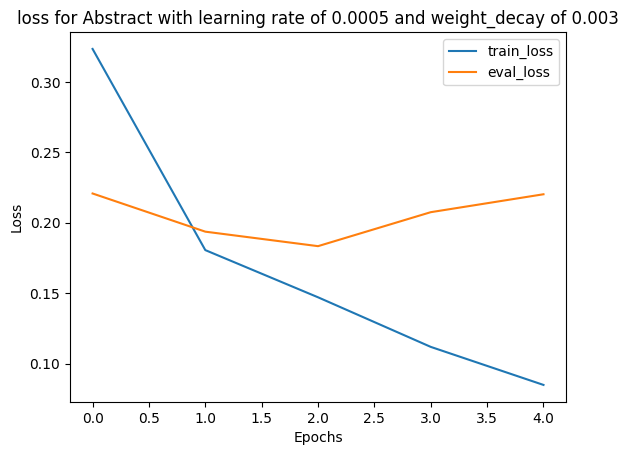

In [35]:

loss_history = {'train_loss':[], 'eval_loss':[]}

# Loop through each log history.
for log_history in abstract_train_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])

  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])

# # Plot Losses.
import matplotlib.pyplot as plt
plt.plot(loss_history['train_loss'])
plt.plot(loss_history['eval_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loss_history.keys())
plt.title(f"loss for Abstract with learning rate of {learning_rate} and weight_decay of {weight_decay}")
plt.savefig(f"{METRICS_PATH}\\bioelectra_abstract_{learning_rate}_{weight_decay}.png")
plt.show()


#### Testing the model

In [36]:
eval_history_abstract = abstract_trainer.evaluate(eval_dataset= abstract_tokenized_dataset['test'])
eval_history_abstract

100%|██████████| 39/39 [00:35<00:00,  1.10it/s]


{'eval_loss': 0.17195309698581696,
 'eval_f1_B-cond': 0.4725274725274725,
 'eval_f1_I-cond': 0.4578884934756821,
 'eval_f1_B-des': 0.4375,
 'eval_f1_I-des': 0.5546875,
 'eval_f1_B-subj': 0.2032520325203252,
 'eval_f1_I-subj': 0.3472222222222222,
 'eval_f1_B-group_A': 0.2847626977518734,
 'eval_f1_I-group_A': 0.14814814814814814,
 'eval_f1_B-group_B': 0.012170385395537525,
 'eval_f1_I-group_B': 0.12716763005780346,
 'eval_f1_B-group_C': 0.0,
 'eval_f1_I-group_C': 0.0,
 'eval_f1_B-group_D': 0.0,
 'eval_f1_I-group_D': 0.0,
 'eval_runtime': 37.0055,
 'eval_samples_per_second': 4.189,
 'eval_steps_per_second': 1.054,
 'epoch': 4.97}

In [37]:
sentence = "Semaglutide, a glucagon-like peptide-1 receptor agonist, has been shown to reduce the risk of adverse cardiovascular events in patients with diabetes. Whether semaglutide can reduce cardiovascular risk associated with overweight and obesity in the absence of diabetes is unknown"

In [38]:
model_checkpoint = abstract_trainer.state.best_model_checkpoint # or save model in disk and load it later
print(f"using checkpoint {model_checkpoint}")

from transformers import pipeline

token_classifier = pipeline("token-classification", model=model_checkpoint, aggregation_strategy="first")
# token_classifier.tokenizer.model_max_length = model_max_length

using checkpoint C:\Users\Gbadamosi\Documents\Nerd Corner\Master in ds and AI\MSC project\workspace\workspace\ner\models\checkpoint-232


In [39]:
res = token_classifier(sentence, aggregation_strategy="first")
print(res)

[]


In [40]:

from datetime import date

today = date.today()

file_name = "eval_history_abstract" +'_'+ str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(eval_history_abstract, save_path)

eval_history_abstract_2023_12_13.json


###  ABSTRACT AND METHODS with punctuation

In [15]:
learning_rate = 5.00E-06
weight_decay = 0.003
print(f"bs: {batch_size}, model_max_length: {model_max_length}, gradient_acc_steps: {gradient_accumulation_steps}, \
n_epochs: {num_train_epochs}, lr: {learning_rate}, weight_decay: {weight_decay}")

bs: 16, model_max_length: 512, gradient_acc_steps: 1, n_epochs: 8, lr: 5e-06, weight_decay: 0.003


In [16]:
for token, label in zip(abstract_meth_with_punc[13]['tokens'], abstract_meth_with_punc[13]['ner_tags']):
    print(f"{token:_<40} {label}")

alpha-dihydroergocryptine_______________ 7
in______________________________________ 0
the_____________________________________ 0
treatment_______________________________ 0
of______________________________________ 0
de______________________________________ 0
novo____________________________________ 0
parkinsonian____________________________ 0
patients________________________________ 0
:_______________________________________ 0
results_________________________________ 0
of______________________________________ 0
a_______________________________________ 0
multicentre_____________________________ 0
,_______________________________________ 0
randomized______________________________ 0
,_______________________________________ 0
double-blind____________________________ 0
,_______________________________________ 0
placebo-controlled______________________ 0
study___________________________________ 0
._______________________________________ 0
introduction____________________________ 0
:__________

#### Creating Huggingface Dataset

In [17]:
abstract_meth_with_punc_hf_ds = create_datasets(abstract_meth_with_punc, tru_label)

Casting the dataset:   0%|          | 0/1549 [00:00<?, ? examples/s]

In [18]:
abstract_meth_with_punc_hf_ds.features

{'pmid': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-cond', 'I-cond', 'B-des', 'I-des', 'B-subj', 'I-subj', 'B-group_A', 'I-group_A', 'B-group_B', 'I-group_B', 'B-group_C', 'I-group_C', 'B-group_D', 'I-group_D'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [19]:
abstract_meth_with_punc_part_train_test = train_test_split(abstract_meth_with_punc_hf_ds, train_test_size=0.2, validation_size=0.5)


In [20]:
abstract_meth_with_punc_part_train_test

DatasetDict({
    train: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 1239
    })
    test: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 155
    })
    valid: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 155
    })
})

In [21]:
tags = abstract_meth_with_punc_part_train_test['train'].features['ner_tags'].feature.names
tags

['O',
 'B-cond',
 'I-cond',
 'B-des',
 'I-des',
 'B-subj',
 'I-subj',
 'B-group_A',
 'I-group_A',
 'B-group_B',
 'I-group_B',
 'B-group_C',
 'I-group_C',
 'B-group_D',
 'I-group_D']

#### tokenizing dataset

In [22]:

abstract_meth_tokenized_dataset = abstract_meth_with_punc_part_train_test.map(tokenize_align_labels, batched = True, remove_columns=abstract_meth_with_punc_part_train_test['train'].column_names)

Map:   0%|          | 0/1239 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

#### Trainer

In [23]:
output_dir = BASE_MODELS_PATH
run_name = "Bioelectra_Abstract_Method"
from transformers import Trainer
args = TrainingArguments(
    output_dir= output_dir,
    evaluation_strategy='epoch',
    eval_steps=1,
    save_strategy = 'epoch',
    learning_rate = learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    gradient_accumulation_steps=gradient_accumulation_steps,
    logging_strategy="epoch",
    save_total_limit=2,
    run_name =run_name,
    load_best_model_at_end=True
)

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, ignore_mismatched_sizes=True, id2label = id2label, label2id = label2id)
abstract_meth_trainer = Trainer(
    model,
    args,
    train_dataset = abstract_meth_tokenized_dataset['train'],
    eval_dataset = abstract_meth_tokenized_dataset['valid'],
    data_collator = data_collator,
    tokenizer = tokenizer,


    compute_metrics = compute_metrics_by_token_swt

)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at kamalkraj/BioELECTRA-PICO and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
abstract_meth_tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1239
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 155
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 155
    })
})

In [25]:
abstract_meth_trainer.train()

model.save_pretrained(MODELS_BASE_PATH)
tokenizer.save_pretrained(MODELS_BASE_PATH)

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 B-cond,F1 I-cond,F1 B-des,F1 I-des,F1 B-subj,F1 I-subj,F1 B-group A,F1 I-group A,F1 B-group B,F1 I-group B,F1 B-group C,F1 I-group C,F1 B-group D,F1 I-group D
1,1.496300,0.334798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.331400,0.278734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.298200,0.245088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.261000,0.223111,0.000000,0.000000,0.000000,0.011958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.241000,0.211943,0.000000,0.000000,0.000000,0.384774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.230100,0.209259,0.000000,0.000000,0.000000,0.551773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.225100,0.205521,0.000000,0.000000,0.000000,0.565217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.222900,0.205484,0.000000,0.000000,0.000000,0.563492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


('/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/vocab.txt',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/tokenizer.json')

#### TESTING AND SAVING THE RESULTS

In [ ]:
abstract_meth_train_history = abstract_meth_trainer.state.log_history
from datetime import date

today = date.today()

file_name = "abstract_meth_train_history" +'_'+ str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(abstract_meth_train_history, save_path)

abstract_train_history_2023_12_13.json


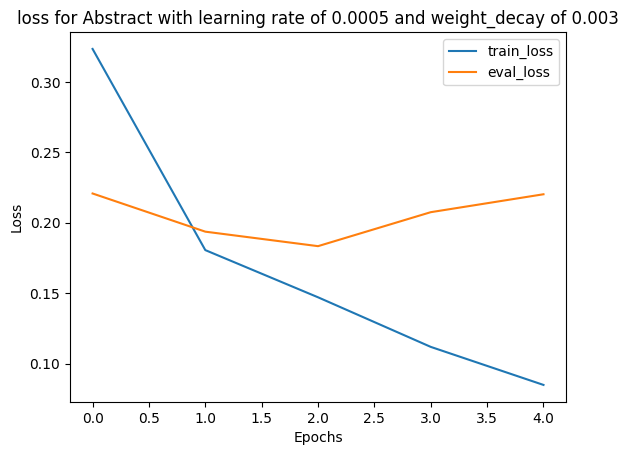

In [ ]:

loss_history = {'train_loss':[], 'eval_loss':[]}

# Loop through each log history.
for log_history in abstract_meth_train_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])

  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])

# # Plot Losses.
import matplotlib.pyplot as plt
plt.plot(loss_history['train_loss'])
plt.plot(loss_history['eval_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loss_history.keys())
plt.title(f"loss for Abstract and method with learning rate of {learning_rate} and weight_decay of {weight_decay}")
plt.savefig(f"{METRICS_PATH}\\bioelectra_abstract_methd_{learning_rate}_{weight_decay}.png")
plt.show()


In [ ]:

from datetime import date

today = date.today()

file_name = "eval_history_abstract_meth" +'_'+ str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(abstract_meth_train_history, save_path)

eval_history_abstract_2023_12_13.json


###  ABSTRACT AND METHODS SPLITTED INTO CHUNKS OF 50 with punctuation

In [33]:
learning_rate = 5.00E-07
weight_decay = 0.003
print(f"bs: {batch_size}, model_max_length: {model_max_length}, gradient_acc_steps: {gradient_accumulation_steps}, \
n_epochs: {num_train_epochs}, lr: {learning_rate}, weight_decay: {weight_decay}")

bs: 16, model_max_length: 512, gradient_acc_steps: 1, n_epochs: 8, lr: 5e-07, weight_decay: 0.003


#### Creating a dataset for training

In [34]:
for token, label in zip(abstract_meth_50_with_punc[0]['tokens'], abstract_meth_50_with_punc[0]['ner_tags']):
    print(f"{token:_<40} {label}")

effects_________________________________ 0
of______________________________________ 0
rivastigmine____________________________ 11
in______________________________________ 0
patients________________________________ 0
with____________________________________ 0
and_____________________________________ 0
without_________________________________ 0
visual__________________________________ 0
hallucinations__________________________ 0
in______________________________________ 0
dementia________________________________ 0
associated______________________________ 0
with____________________________________ 0
parkinson’s_____________________________ 0
disease_________________________________ 0
._______________________________________ 0
we______________________________________ 0
aimed___________________________________ 0
to______________________________________ 0
determine_______________________________ 0
prospectively___________________________ 0
whether_________________________________ 0
rivastigmi

#### Creating Huggingface Dataset

In [35]:
splitted_50_records_method_context_hf_ds = create_datasets(abstract_meth_50_with_punc, tru_label)

Casting the dataset:   0%|          | 0/50046 [00:00<?, ? examples/s]

In [36]:
splitted_50_records_method_context_hf_ds.features

{'pmid': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-cond', 'I-cond', 'B-des', 'I-des', 'B-subj', 'I-subj', 'B-group_A', 'I-group_A', 'B-group_B', 'I-group_B', 'B-group_C', 'I-group_C', 'B-group_D', 'I-group_D'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [37]:
splitted_50_records_method_context_hf_ds[0]


{'pmid': '16960863',
 'ner_tags': [0,
  0,
  11,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'tokens': ['effects',
  'of',
  'rivastigmine',
  'in',
  'patients',
  'with',
  'and',
  'without',
  'visual',
  'hallucinations',
  'in',
  'dementia',
  'associated',
  'with',
  'parkinson’s',
  'disease',
  '.',
  'we',
  'aimed',
  'to',
  'determine',
  'prospectively',
  'whether',
  'rivastigmine',
  ',',
  'an',
  'inhibitor',
  'of',
  'acetylcholinesterase',
  'and',
  'butyrylcholinesterase',
  ',',
  'provided',
  'benefits',
  'in',
  'patients',
  'with',
  'and',
  'without',
  'visual',
  'hallucinations',
  'in',
  'a',
  'population',
  'with',
  'dementia',
  'associated',
  'with',
  "parkinson's",
  'disease']}

In [38]:
splitted_50_records_method_context_train_test_valid = train_test_split(splitted_50_records_method_context_hf_ds, train_test_size=0.2, validation_size=0.5)


In [39]:
splitted_50_records_method_context_train_test_valid

DatasetDict({
    train: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 40036
    })
    test: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 5005
    })
    valid: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 5005
    })
})

In [40]:
tags = splitted_50_records_method_context_train_test_valid['train'].features['ner_tags'].feature.names
tags

['O',
 'B-cond',
 'I-cond',
 'B-des',
 'I-des',
 'B-subj',
 'I-subj',
 'B-group_A',
 'I-group_A',
 'B-group_B',
 'I-group_B',
 'B-group_C',
 'I-group_C',
 'B-group_D',
 'I-group_D']

#### tokenizing dataset

In [41]:
tokenized_50_dataset = splitted_50_records_method_context_train_test_valid.map(tokenize_align_labels, batched = True, remove_columns=splitted_50_records_method_context_train_test_valid['train'].column_names)

Map:   0%|          | 0/40036 [00:00<?, ? examples/s]

Map:   0%|          | 0/5005 [00:00<?, ? examples/s]

Map:   0%|          | 0/5005 [00:00<?, ? examples/s]

#### Trainer

In [43]:
output_dir = r'/content/drive/MyDrive/colab_folder/models/absmeth50chunk'
run_name = 'bio_electra_50_method_abstract'
from transformers import Trainer
args = TrainingArguments(
    output_dir= output_dir,
    evaluation_strategy='epoch',
    eval_steps=1,
    save_strategy = 'epoch',
    learning_rate = learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    gradient_accumulation_steps=gradient_accumulation_steps,
    logging_strategy="epoch",
    save_total_limit=2,
    run_name =run_name,
    load_best_model_at_end=True
)
model_checkpoint = "kamalkraj/BioELECTRA-PICO"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, ignore_mismatched_sizes=True, id2label = id2label, label2id = label2id)
abstract_meth_50_trainer = Trainer(
    model,
    args,
    train_dataset = tokenized_50_dataset['train'],
    eval_dataset = tokenized_50_dataset['valid'],
    data_collator = data_collator,
    tokenizer = tokenizer,


    compute_metrics = compute_metrics_by_token_swt)


Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at kamalkraj/BioELECTRA-PICO and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
tokenized_50_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 40036
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5005
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5005
    })
})

In [45]:
####
abstract_meth_50_trainer.train()

model.save_pretrained('/content/drive/MyDrive/colab_folder/models/Bioelectra/SWT_bioelectra')
tokenizer.save_pretrained('/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer')

Epoch,Training Loss,Validation Loss,F1 B-cond,F1 I-cond,F1 B-des,F1 I-des,F1 B-subj,F1 I-subj,F1 B-group A,F1 I-group A,F1 B-group B,F1 I-group B,F1 B-group C,F1 I-group C,F1 B-group D,F1 I-group D
1,0.427800,0.135841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.134700,0.118371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.118100,0.109107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.109100,0.103499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.104200,0.099830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.101200,0.097675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.099300,0.096796,0.000000,0.000000,0.000000,0.037681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.098400,0.096499,0.000000,0.000000,0.000000,0.059574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


('/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/vocab.txt',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer/tokenizer.json')

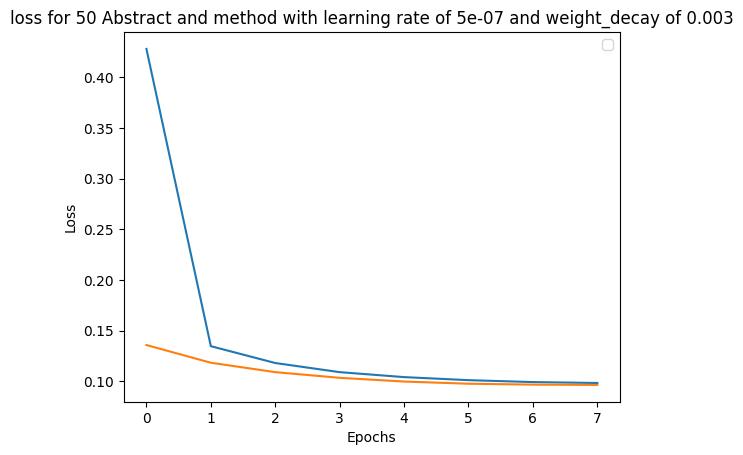

In [46]:
history_50_abstract_method = abstract_meth_50_trainer.state.log_history
loss_history = {'train_loss':[], 'eval_loss':[]}

# Loop through each log history.
for log_history in history_50_abstract_method:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])

  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])

# # Plot Losses.

plt.plot(loss_history['train_loss'])
plt.plot(loss_history['eval_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"loss for 50 Abstract and method with learning rate of {learning_rate} and weight_decay of {weight_decay}")
plt.show()

#### Testing the model

In [ ]:
eval_history_50_abstract_method = abstract_meth_50_trainer.evaluate(eval_dataset= tokenized_50_dataset['test'])
eval_history_50_abstract_method

In [ ]:
sentence = "Semaglutide, a glucagon-like peptide-1 receptor agonist, has been shown to reduce the risk of adverse cardiovascular events in patients with diabetes. Whether semaglutide can reduce cardiovascular risk associated with overweight and obesity in the absence of diabetes is unknown"
sentence

'Semaglutide, a glucagon-like peptide-1 receptor agonist, has been shown to reduce the risk of adverse cardiovascular events in patients with diabetes. Whether semaglutide can reduce cardiovascular risk associated with overweight and obesity in the absence of diabetes is unknown'

In [ ]:
model_checkpoint = abstract_meth_50_trainer.state.best_model_checkpoint # or save model in disk and load it later
print(f"using checkpoint {model_checkpoint}")

from transformers import pipeline

token_classifier = pipeline("token-classification", model=model_checkpoint, aggregation_strategy="first")
# token_classifier.tokenizer.model_max_length = model_max_length

using checkpoint /content/drive/MyDrive/colab_folder/models/absmeth50chunk/checkpoint-20024


In [ ]:
res = token_classifier(sentence, aggregation_strategy="first")
print(res)

In [ ]:
from datetime import date

today = date.today()
files = [history_50_abstract_method, eval_history_50_abstract_method]
file_names = ["history_50_abstract_method", "eval_history_50_abstract_method"]

for file, file_name in zip(files, file_names):
    file_name = file_name +'_'+ str(learning_rate)+ '__' + str(today).replace('-', '_') + '.json'


    save_path = os.path.join(METRICS_PATH, file_name )
    print(file_name)
    write_records(file, save_path)

#### TESTING AND SAVING THE RESULTS

In [ ]:
abstract_train_history = abstract_trainer.state.log_history
from datetime import date

today = date.today()

file_name = "abstract_train_history" +'_'+ str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(abstract_train_history, save_path)

abstract_train_history_2023_12_13.json


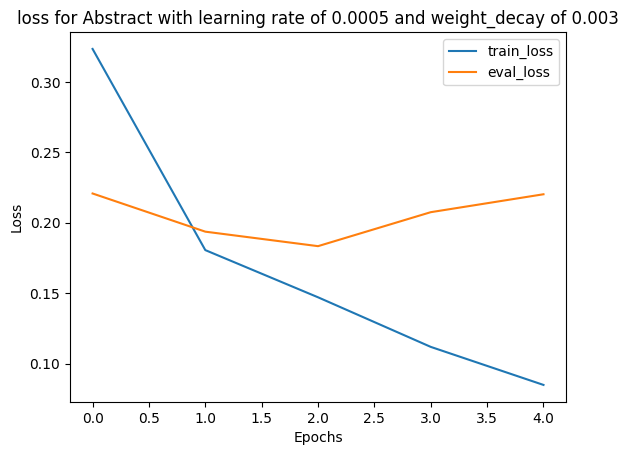

In [ ]:

loss_history = {'train_loss':[], 'eval_loss':[]}

# Loop through each log history.
for log_history in abstract_train_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])

  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])

# # Plot Losses.
import matplotlib.pyplot as plt
plt.plot(loss_history['train_loss'])
plt.plot(loss_history['eval_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loss_history.keys())
plt.title(f"loss for Abstract with learning rate of {learning_rate} and weight_decay of {weight_decay}")
plt.savefig(f"{METRICS_PATH}\\bioelectra_abstract_{learning_rate}_{weight_decay}.png")
plt.show()


In [ ]:

from datetime import date

today = date.today()

file_name = "eval_history_abstract" +'_'+ str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(eval_history_abstract, save_path)

eval_history_abstract_2023_12_13.json


###  ABSTRACT AND METHODS SPLITTED INTO CHUNKS OF 512 with punctuation

In [12]:
learning_rate = 3e-05
weight_decay = 0.003
print(f"bs: {batch_size}, model_max_length: {model_max_length}, gradient_acc_steps: {gradient_accumulation_steps}, \
n_epochs: {num_train_epochs}, lr: {learning_rate}, weight_decay: {weight_decay}")

bs: 4, model_max_length: 512, gradient_acc_steps: 4, n_epochs: 8, lr: 3e-05, weight_decay: 0.003


#### Creating a dataset for training

In [13]:
for token, label in zip(abstract_meth_512_with_punc[0]['tokens'], abstract_meth_512_with_punc[0]['ner_tags']):
    print(f"{token:_<40} {label}")

effects_________________________________ 0
of______________________________________ 0
rivastigmine____________________________ 11
in______________________________________ 0
patients________________________________ 0
with____________________________________ 0
and_____________________________________ 0
without_________________________________ 0
visual__________________________________ 0
hallucinations__________________________ 0
in______________________________________ 0
dementia________________________________ 0
associated______________________________ 0
with____________________________________ 0
parkinson’s_____________________________ 0
disease_________________________________ 0
._______________________________________ 0
we______________________________________ 0
aimed___________________________________ 0
to______________________________________ 0
determine_______________________________ 0
prospectively___________________________ 0
whether_________________________________ 0
rivastigmi

#### Creating Huggingface Dataset

In [14]:
abstract_meth_512_with_punc_hf_ds = create_datasets(abstract_meth_512_with_punc, tru_label)

Casting the dataset: 100%|██████████| 5563/5563 [00:00<00:00, 97860.23 examples/s]


In [15]:
abstract_meth_512_with_punc_hf_ds.features

{'pmid': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-cond', 'I-cond', 'B-des', 'I-des', 'B-subj', 'I-subj', 'B-group_A', 'I-group_A', 'B-group_B', 'I-group_B', 'B-group_C', 'I-group_C', 'B-group_D', 'I-group_D'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [16]:
abstract_meth_512_with_punc_hf_ds[0]


{'pmid': '16960863',
 'ner_tags': [0,
  0,
  11,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  4,
  4,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [17]:
abstract_meth_512_with_punc_train_test_valid = train_test_split(abstract_meth_512_with_punc_hf_ds, train_test_size=0.2, validation_size=0.5)


In [18]:
abstract_meth_512_with_punc_train_test_valid

DatasetDict({
    train: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 4450
    })
    test: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 557
    })
    valid: Dataset({
        features: ['pmid', 'ner_tags', 'tokens'],
        num_rows: 556
    })
})

In [19]:
tags = abstract_meth_512_with_punc_train_test_valid['train'].features['ner_tags'].feature.names
tags

['O',
 'B-cond',
 'I-cond',
 'B-des',
 'I-des',
 'B-subj',
 'I-subj',
 'B-group_A',
 'I-group_A',
 'B-group_B',
 'I-group_B',
 'B-group_C',
 'I-group_C',
 'B-group_D',
 'I-group_D']

#### tokenizing dataset

In [20]:
abstract_meth_512_tokenized_dataset = abstract_meth_512_with_punc_train_test_valid.map(tokenize_align_labels, batched = True,
                                                                                       remove_columns=abstract_meth_512_with_punc_train_test_valid['train'].column_names)

Map:   0%|          | 0/4450 [00:00<?, ? examples/s]

Map: 100%|██████████| 556/556 [00:01<00:00, 404.57 examples/s]


#### Trainer

In [21]:
output_dir = MODELS_BASE_PATH
run_name = 'bio_electra_512_method_abstract'
from transformers import Trainer
args = TrainingArguments(
    output_dir= output_dir,
    evaluation_strategy='epoch',
    eval_steps=1,
    save_strategy = 'epoch',
    learning_rate = learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    gradient_accumulation_steps=gradient_accumulation_steps,
    logging_strategy="epoch",
    save_total_limit=2,
    run_name =run_name,
    load_best_model_at_end=True
)
model_checkpoint = "kamalkraj/BioELECTRA-PICO"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, ignore_mismatched_sizes=True, id2label = id2label, label2id = label2id)
abstract_meth_512_trainer = Trainer(
    model,
    args,
    train_dataset = abstract_meth_512_tokenized_dataset['train'],
    eval_dataset = abstract_meth_512_tokenized_dataset['valid'],
    data_collator = data_collator,
    tokenizer = tokenizer,


    compute_metrics = compute_metrics_by_token_swt)


Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at kamalkraj/BioELECTRA-PICO and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:

abstract_meth_512_tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4450
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 557
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 556
    })
})

In [23]:
tru_label

['O',
 'B-cond',
 'I-cond',
 'B-des',
 'I-des',
 'B-subj',
 'I-subj',
 'B-group_A',
 'I-group_A',
 'B-group_B',
 'I-group_B',
 'B-group_C',
 'I-group_C',
 'B-group_D',
 'I-group_D']

In [24]:
abstract_meth_512_trainer.train()

model.save_pretrained('/content/drive/MyDrive/colab_folder/models/Bioelectra/SWT_bioelectra')
tokenizer.save_pretrained('/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer')

  0%|          | 0/2224 [00:00<?, ?it/s]You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


 12%|█▎        | 278/2224 [1:18:40<8:58:44, 16.61s/it]

{'loss': 0.2065, 'learning_rate': 2.625e-05, 'epoch': 1.0}


                                                      
 12%|█▎        | 278/2224 [1:21:22<8:58:44, 16.61s/it]

{'eval_loss': 0.09100828319787979, 'eval_f1_B-cond': 0.0, 'eval_f1_I-cond': 0.0, 'eval_f1_B-des': 0.0, 'eval_f1_I-des': 0.5055555555555554, 'eval_f1_B-subj': 0.0, 'eval_f1_I-subj': 0.0, 'eval_f1_B-group_A': 0.0, 'eval_f1_I-group_A': 0.0, 'eval_f1_B-group_B': 0.0, 'eval_f1_I-group_B': 0.0, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': 0.0, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 161.3015, 'eval_samples_per_second': 3.447, 'eval_steps_per_second': 0.862, 'epoch': 1.0}


 25%|██▌       | 556/2224 [2:38:36<7:42:08, 16.62s/it] 

{'loss': 0.0811, 'learning_rate': 2.25e-05, 'epoch': 2.0}


C:\Users\Gbadamosi\AppData\Local\Temp\ipykernel_25304\415897817.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * prec * rec / (prec + rec)
                                                      
 25%|██▌       | 556/2224 [2:41:08<7:42:08, 16.62s/it]

{'eval_loss': 0.07491040974855423, 'eval_f1_B-cond': 0.0, 'eval_f1_I-cond': 0.0, 'eval_f1_B-des': 0.0, 'eval_f1_I-des': 0.4963942307692308, 'eval_f1_B-subj': 0.0, 'eval_f1_I-subj': 0.0, 'eval_f1_B-group_A': 0.13106796116504857, 'eval_f1_I-group_A': nan, 'eval_f1_B-group_B': 0.043478260869565216, 'eval_f1_I-group_B': 0.0, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': 0.0, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 152.1942, 'eval_samples_per_second': 3.653, 'eval_steps_per_second': 0.913, 'epoch': 2.0}


 38%|███▊      | 834/2224 [3:59:29<6:22:27, 16.51s/it] 

{'loss': 0.0651, 'learning_rate': 1.8750000000000002e-05, 'epoch': 3.0}


C:\Users\Gbadamosi\AppData\Local\Temp\ipykernel_25304\415897817.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * prec * rec / (prec + rec)
                                                      
 38%|███▊      | 834/2224 [4:02:00<6:22:27, 16.51s/it]

{'eval_loss': 0.06999535858631134, 'eval_f1_B-cond': 0.1607717041800643, 'eval_f1_I-cond': 0.31432192648922685, 'eval_f1_B-des': 0.4646017699115044, 'eval_f1_I-des': 0.6495066495066495, 'eval_f1_B-subj': 0.09448818897637795, 'eval_f1_I-subj': 0.39231824417009603, 'eval_f1_B-group_A': 0.5123152709359605, 'eval_f1_I-group_A': 0.13168724279835392, 'eval_f1_B-group_B': 0.44255319148936173, 'eval_f1_I-group_B': 0.02693602693602694, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': nan, 'eval_f1_B-group_D': 0.0, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 150.858, 'eval_samples_per_second': 3.686, 'eval_steps_per_second': 0.921, 'epoch': 3.0}


 50%|█████     | 1113/2224 [5:18:23<4:50:50, 15.71s/it]

{'loss': 0.0541, 'learning_rate': 1.4986510791366906e-05, 'epoch': 4.0}


C:\Users\Gbadamosi\AppData\Local\Temp\ipykernel_25304\415897817.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * prec * rec / (prec + rec)
                                                       
 50%|█████     | 1113/2224 [5:20:18<4:50:50, 15.71s/it]

{'eval_loss': 0.07216488569974899, 'eval_f1_B-cond': 0.3191919191919192, 'eval_f1_I-cond': 0.43287225386493083, 'eval_f1_B-des': 0.5110663983903421, 'eval_f1_I-des': 0.6622103386809269, 'eval_f1_B-subj': 0.28169014084507044, 'eval_f1_I-subj': 0.3659108678655199, 'eval_f1_B-group_A': 0.504778761061947, 'eval_f1_I-group_A': 0.34905660377358494, 'eval_f1_B-group_B': 0.4648359008707301, 'eval_f1_I-group_B': 0.1629327902240326, 'eval_f1_B-group_C': 0.0, 'eval_f1_I-group_C': nan, 'eval_f1_B-group_D': 0.345679012345679, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 114.1187, 'eval_samples_per_second': 4.872, 'eval_steps_per_second': 1.218, 'epoch': 4.0}


 63%|██████▎   | 1391/2224 [6:36:53<3:49:10, 16.51s/it] 

{'loss': 0.0462, 'learning_rate': 1.1236510791366906e-05, 'epoch': 5.0}


C:\Users\Gbadamosi\AppData\Local\Temp\ipykernel_25304\415897817.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * prec * rec / (prec + rec)
                                                       
 63%|██████▎   | 1391/2224 [6:39:32<3:49:10, 16.51s/it]

{'eval_loss': 0.0725502073764801, 'eval_f1_B-cond': 0.3427495291902071, 'eval_f1_I-cond': 0.4003021148036254, 'eval_f1_B-des': 0.5000000000000001, 'eval_f1_I-des': 0.6525911708253358, 'eval_f1_B-subj': 0.25210084033613445, 'eval_f1_I-subj': 0.39657282741738065, 'eval_f1_B-group_A': 0.47781299524564186, 'eval_f1_I-group_A': 0.3203463203463203, 'eval_f1_B-group_B': 0.44315648684797143, 'eval_f1_I-group_B': 0.1981981981981982, 'eval_f1_B-group_C': 0.010582010582010583, 'eval_f1_I-group_C': nan, 'eval_f1_B-group_D': 0.4230769230769231, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 159.401, 'eval_samples_per_second': 3.488, 'eval_steps_per_second': 0.872, 'epoch': 5.0}


 75%|███████▌  | 1669/2224 [7:56:10<2:32:23, 16.48s/it] 

{'loss': 0.0403, 'learning_rate': 7.486510791366907e-06, 'epoch': 6.0}


                                                       
 75%|███████▌  | 1669/2224 [7:58:40<2:32:23, 16.48s/it]

{'eval_loss': 0.0737151950597763, 'eval_f1_B-cond': 0.36454849498327757, 'eval_f1_I-cond': 0.44119795471146817, 'eval_f1_B-des': 0.4972577696526508, 'eval_f1_I-des': 0.663358147229115, 'eval_f1_B-subj': 0.30689655172413793, 'eval_f1_I-subj': 0.39220183486238536, 'eval_f1_B-group_A': 0.5211214953271027, 'eval_f1_I-group_A': 0.31843575418994413, 'eval_f1_B-group_B': 0.49750249750249753, 'eval_f1_I-group_B': 0.1976401179941003, 'eval_f1_B-group_C': 0.04060913705583757, 'eval_f1_I-group_C': 0.015267175572519083, 'eval_f1_B-group_D': 0.3863636363636363, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 150.4018, 'eval_samples_per_second': 3.697, 'eval_steps_per_second': 0.924, 'epoch': 6.0}


 88%|████████▊ | 1947/2224 [9:15:11<1:16:14, 16.51s/it]

{'loss': 0.036, 'learning_rate': 3.7365107913669067e-06, 'epoch': 7.0}


                                                       
 88%|████████▊ | 1947/2224 [9:17:42<1:16:14, 16.51s/it]

{'eval_loss': 0.07501372694969177, 'eval_f1_B-cond': 0.37110016420361247, 'eval_f1_I-cond': 0.4176157934700076, 'eval_f1_B-des': 0.5188118811881189, 'eval_f1_I-des': 0.6651923927465724, 'eval_f1_B-subj': 0.3280757097791798, 'eval_f1_I-subj': 0.3898678414096916, 'eval_f1_B-group_A': 0.5008250825082509, 'eval_f1_I-group_A': 0.33498513379583744, 'eval_f1_B-group_B': 0.5153308230231307, 'eval_f1_I-group_B': 0.20195439739413681, 'eval_f1_B-group_C': 0.13913043478260867, 'eval_f1_I-group_C': 0.13414634146341464, 'eval_f1_B-group_D': 0.3908045977011494, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 150.5115, 'eval_samples_per_second': 3.694, 'eval_steps_per_second': 0.924, 'epoch': 7.0}


100%|██████████| 2224/2224 [10:33:52<00:00, 16.51s/it] 

{'loss': 0.0326, 'learning_rate': 0.0, 'epoch': 7.99}


                                                      
100%|██████████| 2224/2224 [10:35:46<00:00, 16.51s/it]

{'eval_loss': 0.07626016438007355, 'eval_f1_B-cond': 0.37209302325581395, 'eval_f1_I-cond': 0.42824251726784346, 'eval_f1_B-des': 0.5254582484725051, 'eval_f1_I-des': 0.668521094112193, 'eval_f1_B-subj': 0.32572298325722976, 'eval_f1_I-subj': 0.3958974358974359, 'eval_f1_B-group_A': 0.4994007191370356, 'eval_f1_I-group_A': 0.33266533066132264, 'eval_f1_B-group_B': 0.5219750406945197, 'eval_f1_I-group_B': 0.1984251968503937, 'eval_f1_B-group_C': 0.07272727272727272, 'eval_f1_I-group_C': 0.06756756756756757, 'eval_f1_B-group_D': 0.38554216867469876, 'eval_f1_I-group_D': 0.0, 'eval_runtime': 113.9361, 'eval_samples_per_second': 4.88, 'eval_steps_per_second': 1.22, 'epoch': 7.99}


100%|██████████| 2224/2224 [10:35:55<00:00, 17.16s/it]


{'train_runtime': 38154.9441, 'train_samples_per_second': 0.933, 'train_steps_per_second': 0.058, 'train_loss': 0.07023427512148302, 'epoch': 7.99}


('/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\tokenizer_config.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\special_tokens_map.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\vocab.txt',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\added_tokens.json',
 '/content/drive/MyDrive/colab_folder/tokenizer/Bioelectra/SWT_bioelectra_tokenizer\\tokenizer.json')

#### TESTING AND SAVING THE RESULTS

In [25]:
abstract_meth_512_train_history = abstract_meth_512_trainer.state.log_history
from datetime import date

today = date.today()

file_name = "abstract_meth_512_train_history" +'_'+ str(learning_rate) + str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(abstract_meth_512_train_history, save_path)

abstract_meth_512_train_history_3e-052023_12_15.json


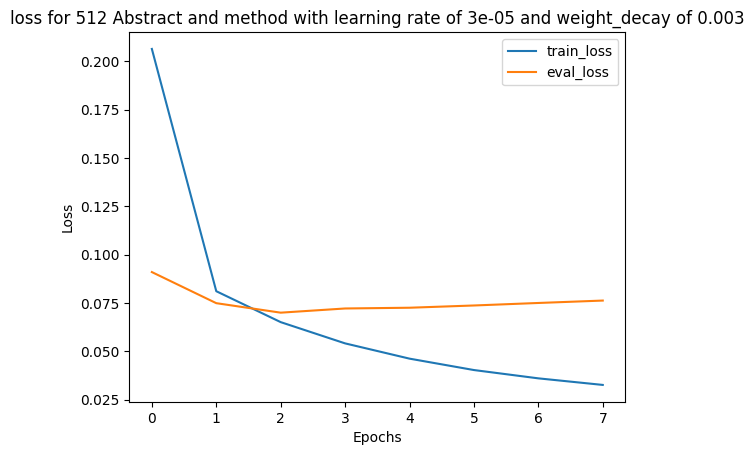

In [26]:

loss_history = {'train_loss':[], 'eval_loss':[]}

# Loop through each log history.
for log_history in abstract_meth_512_train_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])

  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])

# # Plot Losses.
import matplotlib.pyplot as plt
plt.plot(loss_history['train_loss'])
plt.plot(loss_history['eval_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loss_history.keys())
plt.title(f"loss for 512 Abstract and method with learning rate of {learning_rate} and weight_decay of {weight_decay}")
plt.savefig(f"{METRICS_PATH}\\bioelectra_512_abstract_methd_{learning_rate}_{weight_decay}.png")
plt.show()


#### Testing the model

In [27]:
eval_history_512_abstract_method = abstract_meth_512_trainer.evaluate(eval_dataset= abstract_meth_512_tokenized_dataset['test'])
eval_history_512_abstract_method

100%|██████████| 140/140 [01:52<00:00,  1.25it/s]


{'eval_loss': 0.07385022193193436,
 'eval_f1_B-cond': 0.11688311688311688,
 'eval_f1_I-cond': 0.30618253189401373,
 'eval_f1_B-des': 0.45147679324894513,
 'eval_f1_I-des': 0.5459866220735786,
 'eval_f1_B-subj': 0.07211538461538462,
 'eval_f1_I-subj': 0.46204620462046203,
 'eval_f1_B-group_A': 0.43623070674248576,
 'eval_f1_I-group_A': 0.2793791574279379,
 'eval_f1_B-group_B': 0.384703196347032,
 'eval_f1_I-group_B': 0.26865671641791045,
 'eval_f1_B-group_C': 0.0,
 'eval_f1_I-group_C': 0.05235602094240837,
 'eval_f1_B-group_D': 0.0,
 'eval_f1_I-group_D': 0.0,
 'eval_runtime': 113.0807,
 'eval_samples_per_second': 4.926,
 'eval_steps_per_second': 1.238,
 'epoch': 7.99}

In [28]:
sentence = "Semaglutide, a glucagon-like peptide-1 receptor agonist, has been shown to reduce the risk of adverse cardiovascular events in patients with diabetes. Whether semaglutide can reduce cardiovascular risk associated with overweight and obesity in the absence of diabetes is unknown"
sentence

'Semaglutide, a glucagon-like peptide-1 receptor agonist, has been shown to reduce the risk of adverse cardiovascular events in patients with diabetes. Whether semaglutide can reduce cardiovascular risk associated with overweight and obesity in the absence of diabetes is unknown'

In [29]:
model_checkpoint = abstract_meth_512_trainer.state.best_model_checkpoint # or save model in disk and load it later
print(f"using checkpoint {model_checkpoint}")

from transformers import pipeline

token_classifier = pipeline("token-classification", model=model_checkpoint, aggregation_strategy="first")
# token_classifier.tokenizer.model_max_length = model_max_length

using checkpoint C:\Users\Gbadamosi\Documents\Nerd Corner\Master in ds and AI\MSC project\workspace\workspace\ner\models\checkpoint-834


In [30]:
res = token_classifier(sentence, aggregation_strategy="first")
print(res)

[{'entity_group': 'group_A', 'score': 0.5932187, 'word': 'semaglutide', 'start': 0, 'end': 11}, {'entity_group': 'group_A', 'score': 0.5633252, 'word': 'semaglutide', 'start': 159, 'end': 170}]


In [31]:

from datetime import date

today = date.today()

file_name = "eval_history_512_abstract_method" +'_'+ str(learning_rate) +  str(today).replace('-', '_') + '.json'

save_path = os.path.join(METRICS_PATH, file_name )
print(file_name)
write_records(eval_history_512_abstract_method, save_path)

eval_history_512_abstract_method_3e-052023_12_15.json


### Visualizing results

In [32]:
# # eval_history_512_abstract_method
# # eval_history_50_abstract_method
# # eval_history_abstract_method
# # eval_history_abstract
# import numpy as np
# import matplotlib.pyplot as plt

# X = ['512_abstract_method','50_abstract_method','abstract_method','abstract']
# f1_B_cond = [10,20,20,40]
# f1_I_cond = [20,30,25,30]
# f1_B_des= [15, 10, 20, 35]
# f1_I_des= [5, 20, 35, 50]
# #  'eval_f1_B-subj': 0.021621621621621623,
# #  'eval_f1_I-subj': 0.0,
#  'eval_f1_B-group_A': 0.22835394862036157,
# #  'eval_f1_I-group_A': 0.0,
# #  'eval_f1_B-group_B': 0.0,
# #  'eval_f1_I-group_B': 0.0,
# #  'eval_f1_B-group_C': 0.0,
# #  'eval_f1_I-group_C': 0.0,
# #  'eval_f1_B-group_D': 0.0,
# #  'eval_f1_I-group_D': 0.0,
# #  'eval_f1_B-proc': 0.0,
# #  'eval_f1_I-proc': 0.0,
# #  'eval_f1_B-N_A': 0.0,
# #  'eval_f1_I-N_A': 0.0,
# #  'eval_f1_B-N_B': 0.0,
# #  'eval_f1_I-N_B': 0.0,
# #  'eval_f1_B-ther': 0.0,
# #  'eval_f1_I-ther': 0.0,

# X_axis = np.arange(len(X))

# plt.bar(X_axis - 0.1, f1_B_cond, 0.4, label = 'f1_B_cond')
# plt.bar(X_axis + 0.1, f1_I_cond, 0.4, label = 'f1_I_cond')
# plt.bar(X_axis - 0.2, f1_B_des, 0.4, label = 'f1_B_des')
# plt.bar(X_axis + 0.2, f1_I_des, 0.4, label = 'f1_I_des')

# plt.xticks(X_axis, X)
# plt.xlabel("Groups")
# plt.ylabel("F1 SCORES")
# plt.title("Number of Students in each group")
# plt.legend()
# plt.show()
